In [455]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split
# from prophet import Prophet

In [456]:
df = pd.read_csv('C:/Users/norri/Desktop/amazon.csv')
df = df[df['client_name'] == 'KIND']
df = df.drop_duplicates(subset=['sales', 'week'])
print(df)

     client_name brand_name        week    campaign_type  \
0           KIND       KIND   1/31/2021  sponsoredBrands   
11          KIND       KIND  11/22/2020  sponsoredBrands   
34          KIND       KIND    1/6/2019  sponsoredBrands   
60          KIND       KIND  12/26/2021  sponsoredBrands   
82          KIND       KIND   6/21/2020  sponsoredBrands   
...          ...        ...         ...              ...   
3239        KIND       KIND   5/26/2019  sponsoredBrands   
3247        KIND       KIND    9/6/2020  sponsoredBrands   
3261        KIND       KIND    2/6/2022  sponsoredBrands   
3274        KIND       KIND   8/11/2019  sponsoredBrands   
3290        KIND       KIND  11/14/2021  sponsoredBrands   

     primary_search_strategy    spend  impressions  clicks  attributed_sales  \
0                    Branded  6658.83     306608.0  2448.0          19079.06   
11                   Branded  1921.19     140083.0   866.0           5836.04   
34                   Branded  6743.75  

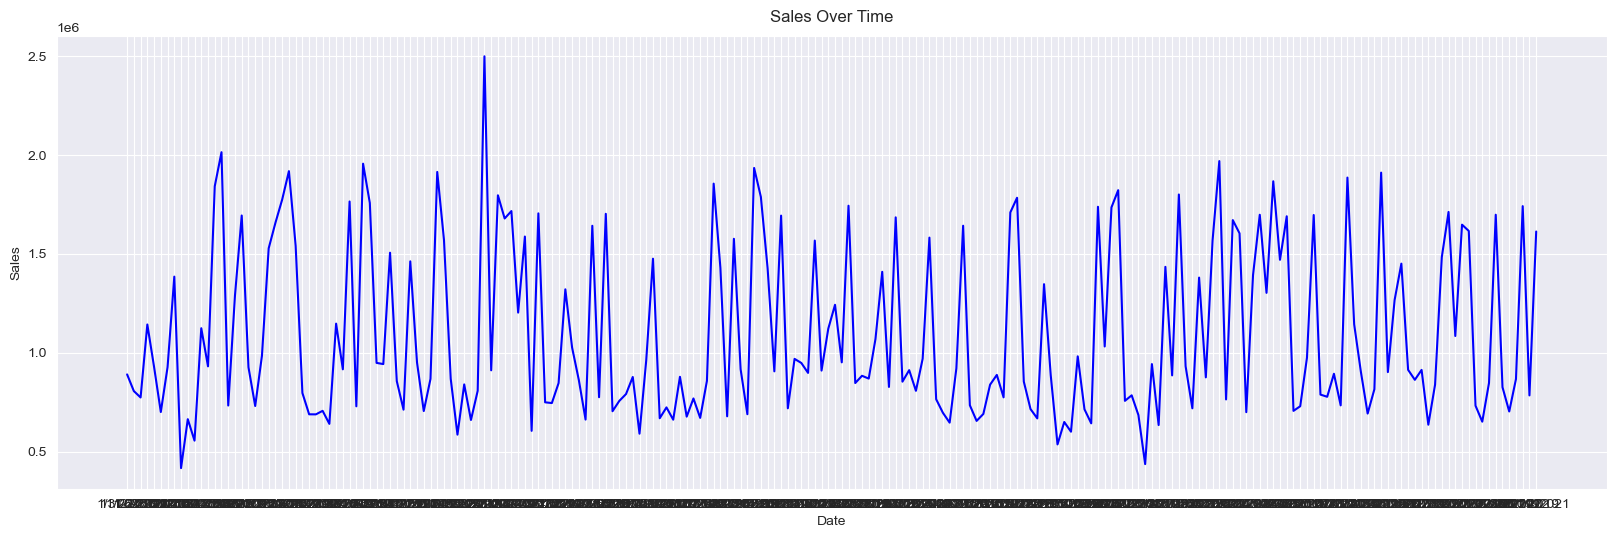

In [457]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Sales', dpi=100):
    plt.figure(figsize=(20, 6), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df['week'], y=df['sales'], title='Sales Over Time')

Both plots appear to demonstrate a slight degree of annual cycles

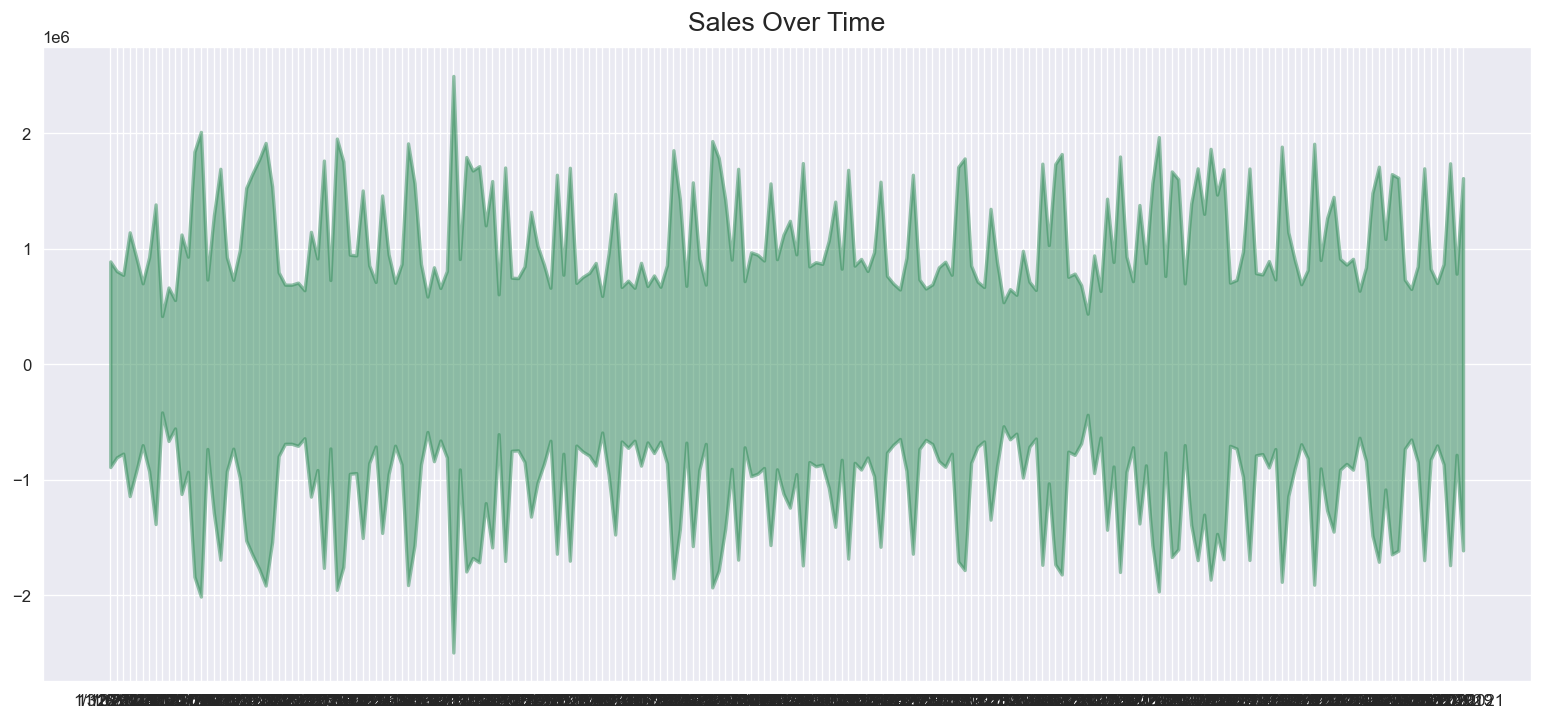

In [458]:
x = df['week'].values
y1 = df['sales'].values
fig, ax = plt.subplots(1, 1, figsize=(16,7), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.title('Sales Over Time', fontsize=16)
plt.show()

Value = Base Level + Trend + Seasonality + Error - Additive Decomposition
Value = Base Level x Trend x Seasonality x Error - Multiplicative Decompisition

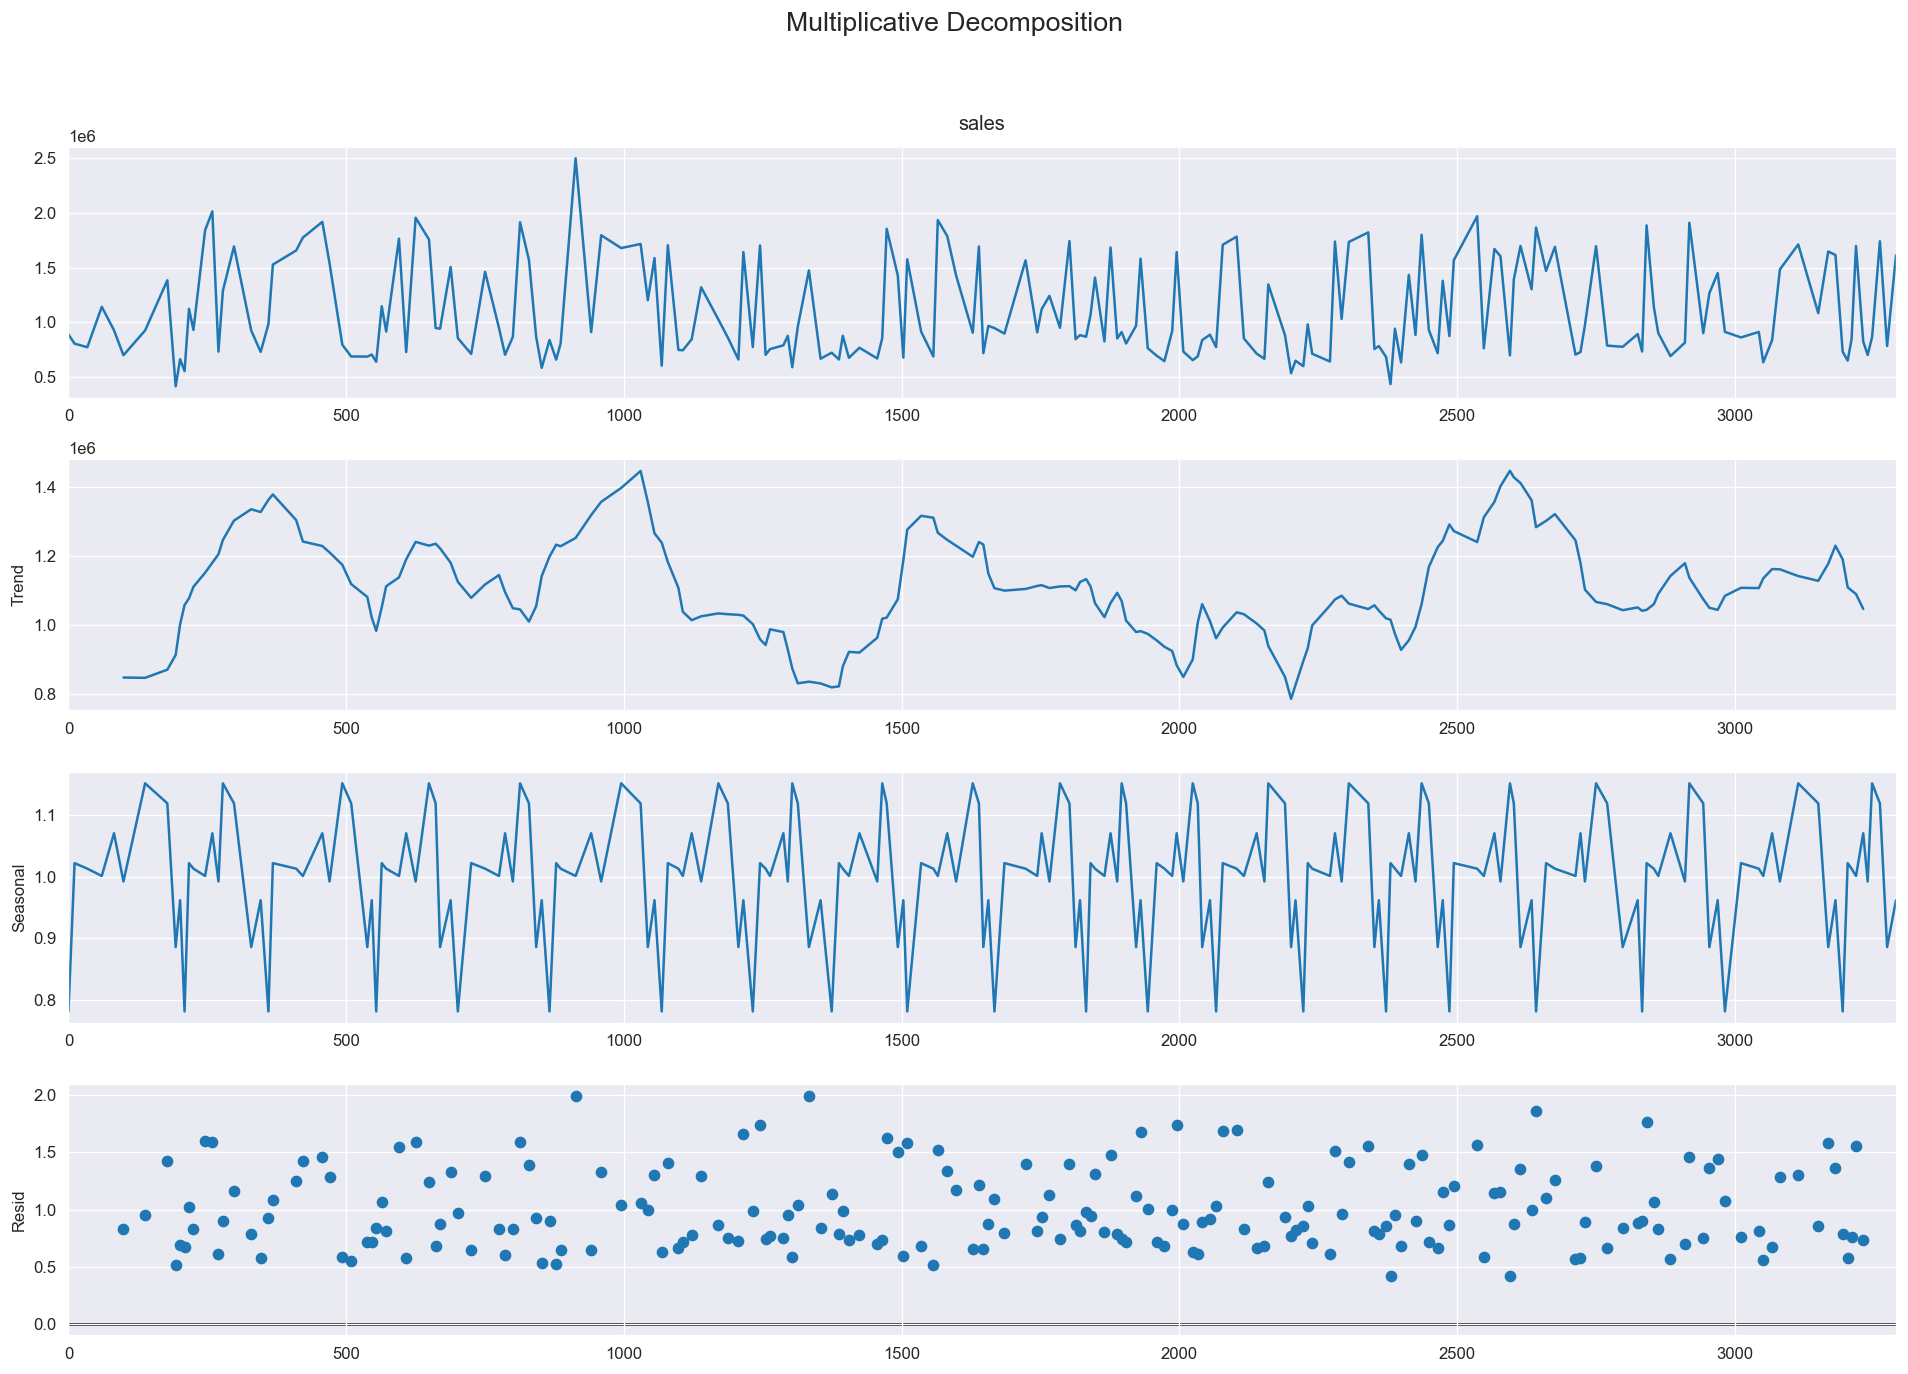

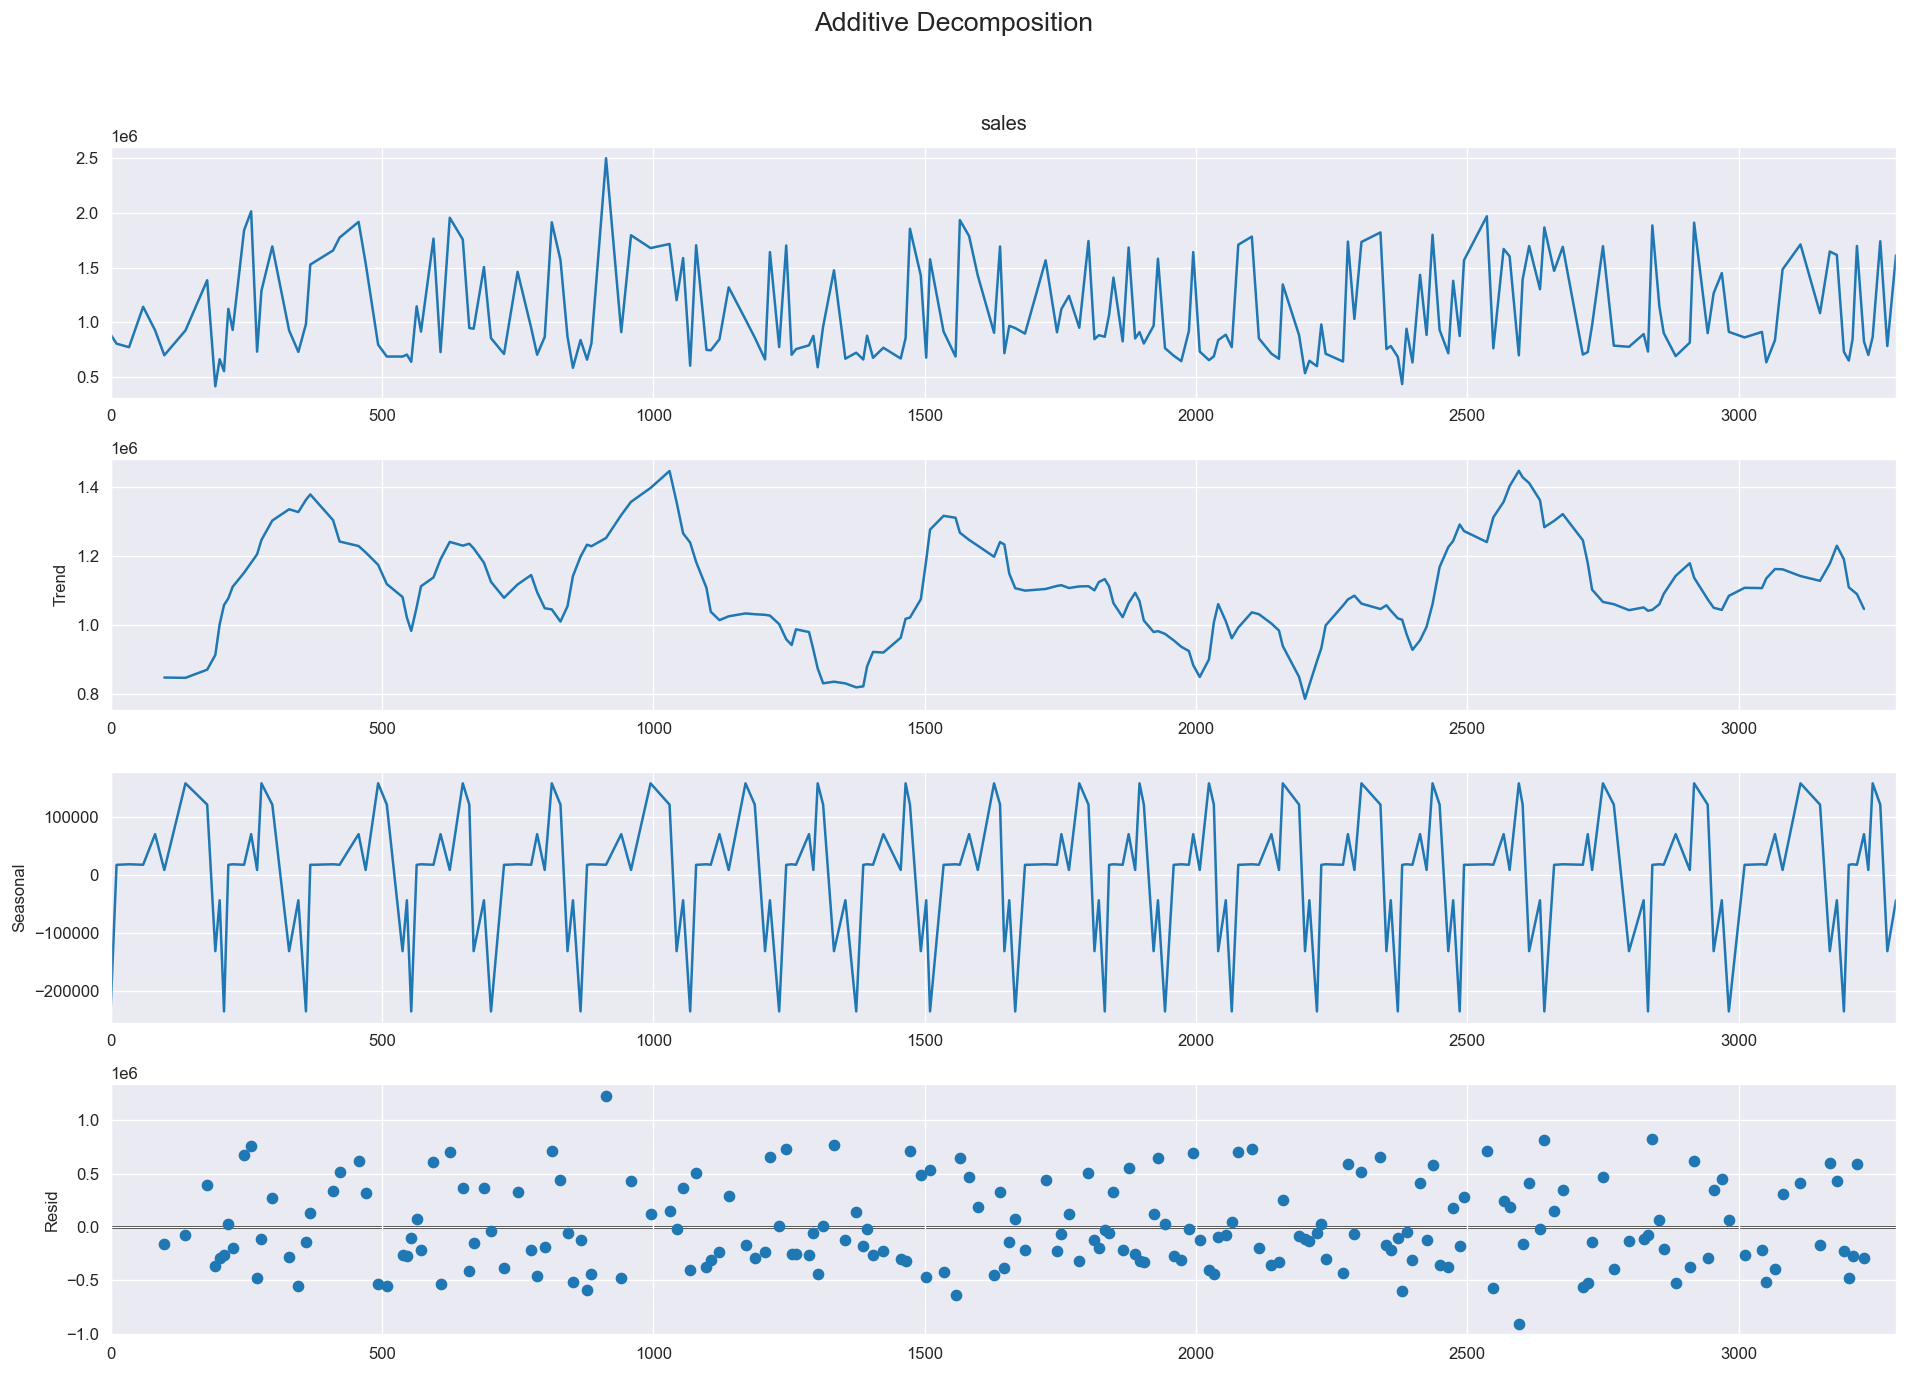

In [459]:
multiplicative_decomposition = seasonal_decompose(df['sales'], model='multiplicative',
                                                  period=10)

additive_decomposition = seasonal_decompose(df['sales'], model='additive', period=10)

plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Variance of Residuals appear to be random and similar between additive and multiplicative

Text(0.5, 1.0, 'Sales Detrended')

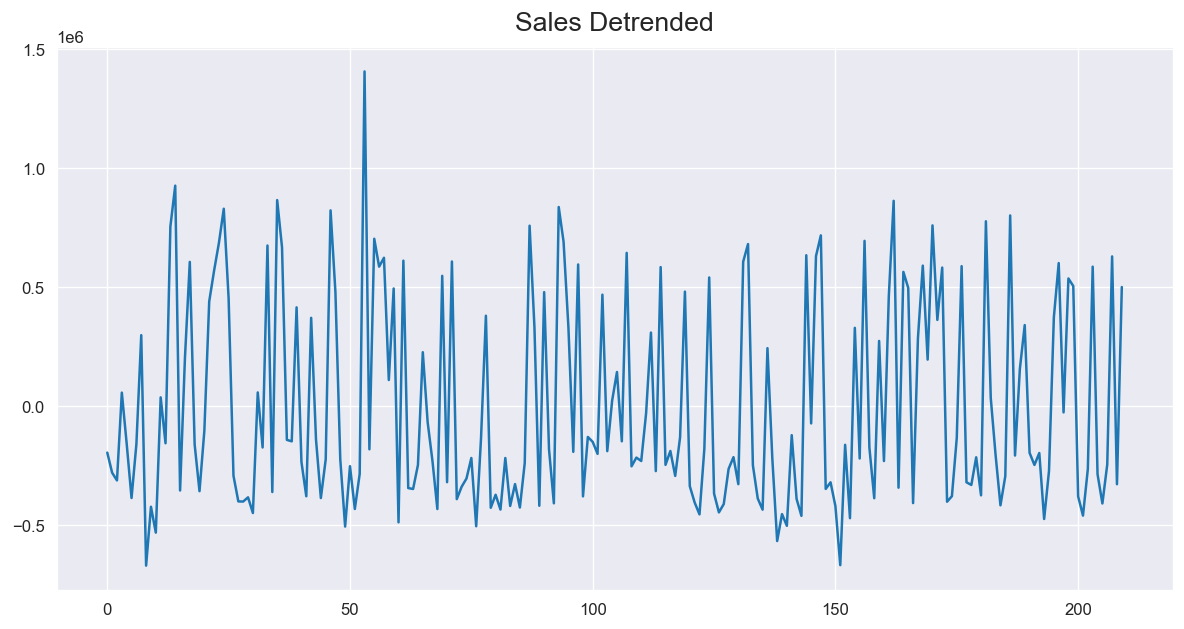

In [460]:
detrended = signal.detrend(df['sales'].values)
plt.rcParams.update({'figure.figsize': (12,6)})
plt.plot(detrended)
plt.title('Sales Detrended', fontsize=16)

[]

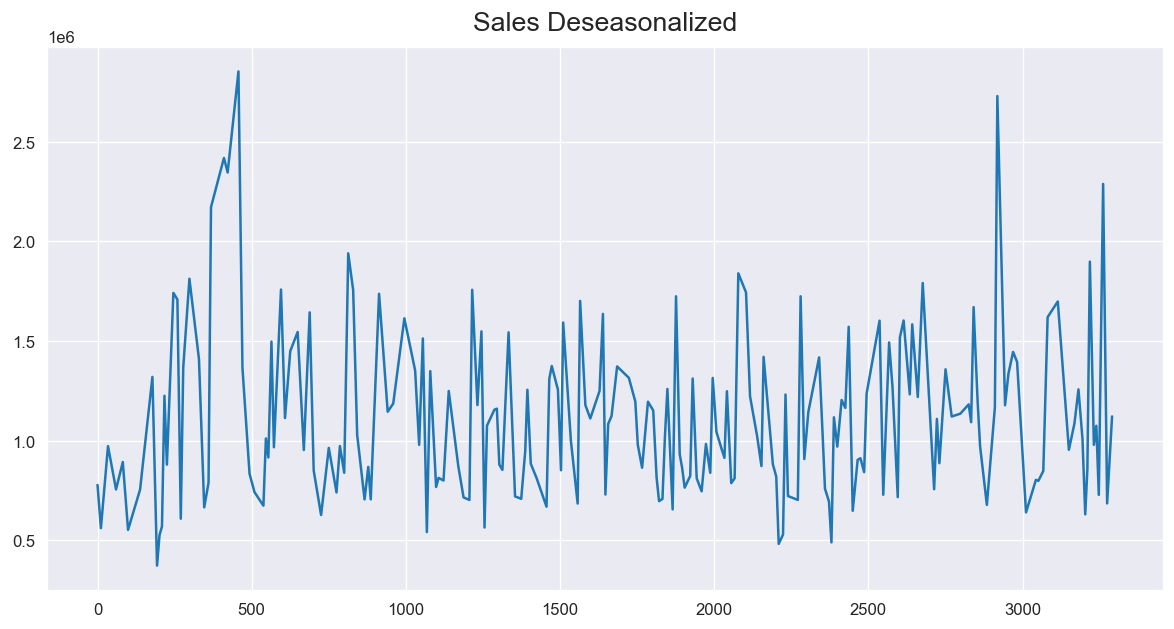

In [461]:
result_mul = seasonal_decompose(df['sales'], model='multiplicative', period=52)

deseasonalized = df['sales'].values / result_mul.seasonal

plt.plot(deseasonalized)
plt.title('Sales Deseasonalized', fontsize=16)
plt.plot()

Detrending and deasonalization show both a nonconstant variance and seasonality

Text(0.5, 1.0, 'Sales detrended')

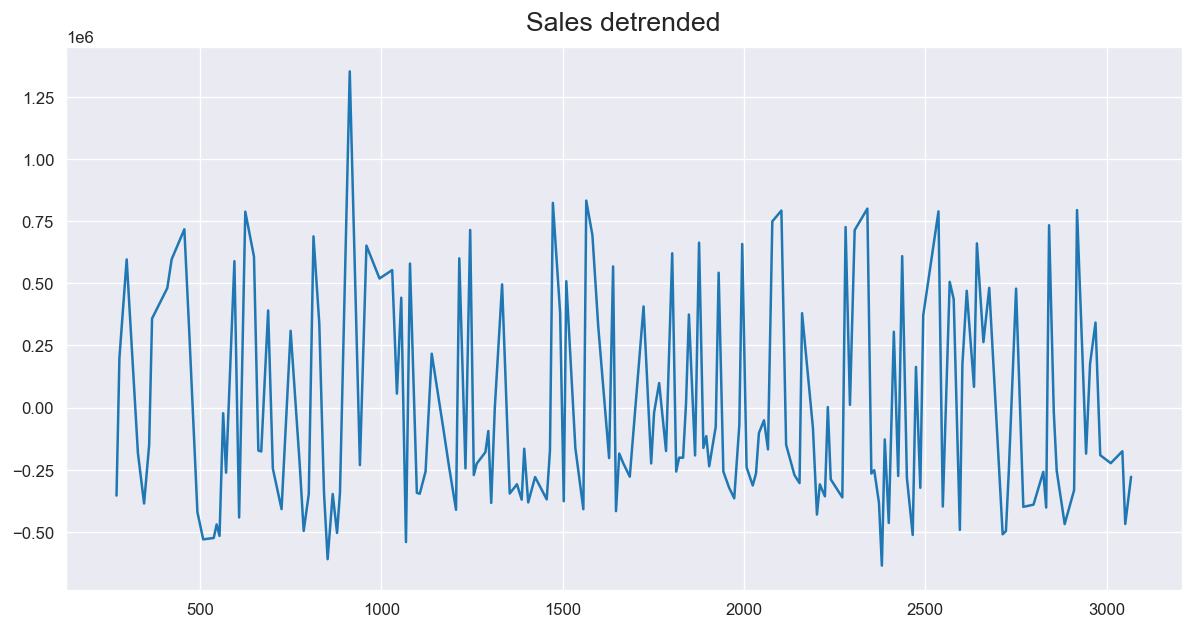

In [462]:
result_mul = seasonal_decompose(df['sales'], model='multiplicative', period=30)
detrended = df['sales'].values - result_mul.trend
plt.plot(detrended)
plt.title('Sales detrended', fontsize=16)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

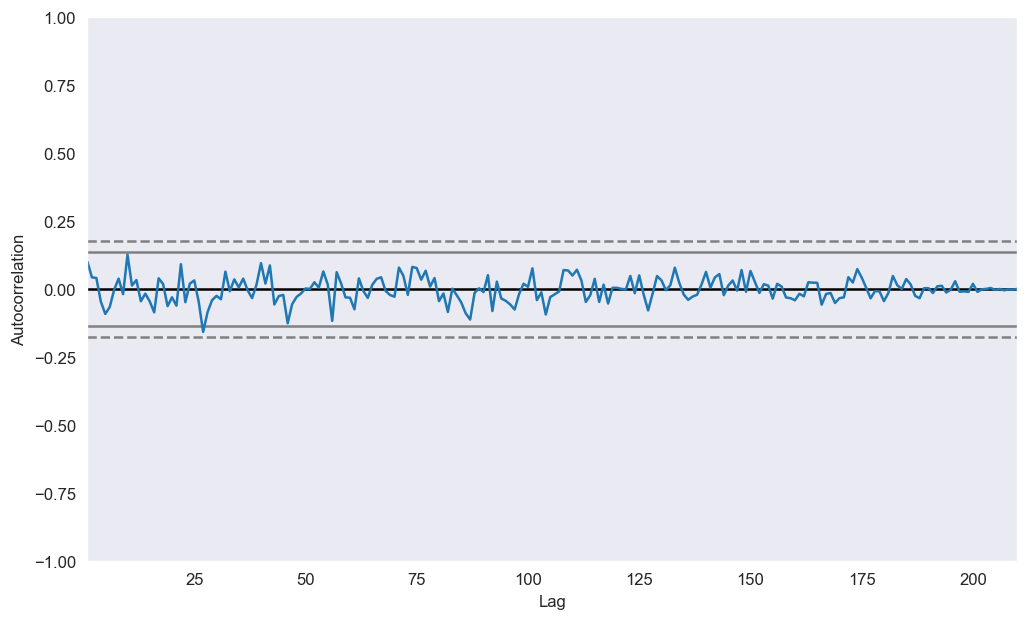

In [463]:
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(df['sales'].tolist())

Spikes demonstrate seasonality with slight degree of autocorrelation

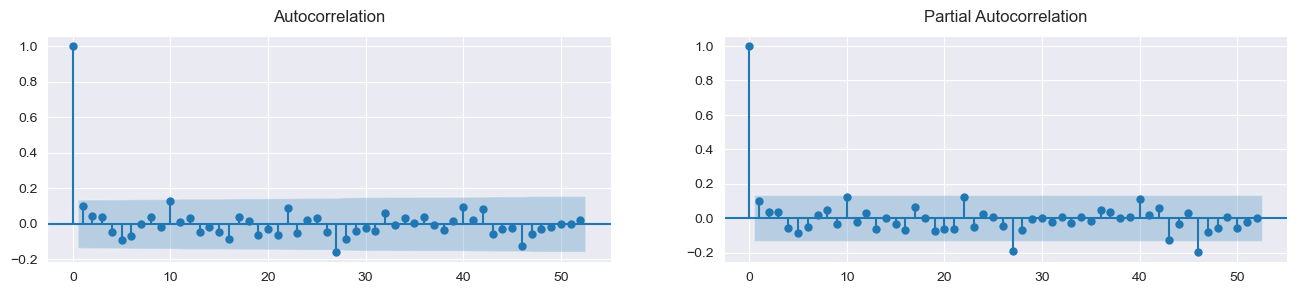

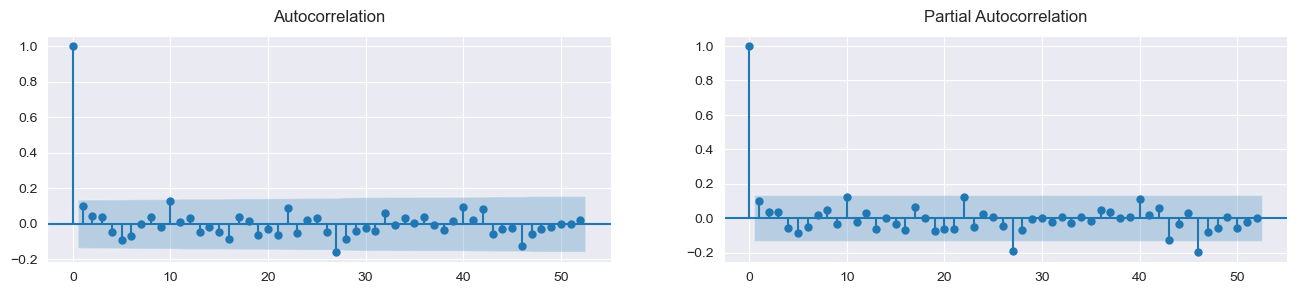

In [464]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3), dpi=100)
plot_acf(df['sales'].tolist(), lags=52, ax=axes[0])
plot_pacf(df['sales'].tolist(), lags=52, ax=axes[1])


Similar annual seasonality trends appear with peaks and valleys
on weekly basis

In [465]:
ac1 = df['sales'].autocorr(lag=1)
print("One week Lag: ", ac1)
ac2 = df['sales'].autocorr(lag=2)
print("Two week Lag: ", ac2)
ac3 = df['sales'].autocorr(lag=3)
print("Three week Lag: ", ac3)
ac4 = df['sales'].autocorr(lag=4)
print("Four Week Lag: ", ac4)
ac5 = df['sales'].autocorr(lag=5)
print("Five Week Lag: ", ac5)

One week Lag:  0.10050013754135359
Two week Lag:  0.042676309046204
Three week Lag:  0.04065408276106072
Four Week Lag:  -0.046827369198169266
Five Week Lag:  -0.09356880139748111


Demonstration of small autocorrelation with lag

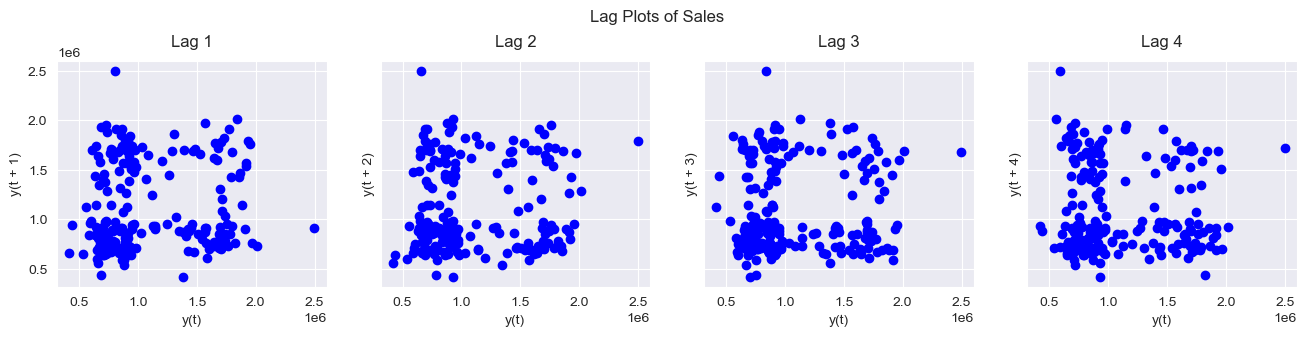

In [466]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

fig, axes = plt.subplots(1, 4, figsize=(16, 3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df['sales'], lag=i+1, ax=ax, c='blue')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Sales', y=1.05)
plt.show()

Decreasing linear trend between lag plots demonstrates similar results to
lag scores, suggesting some positive autocorrelation between first week

In [467]:
X_train, X_test, y_train, y_test = train_test_split(df['week'], df['sales'],
                                                    test_size=0.30,
                                                    random_state=13)
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)
forecast = model.predict(n_periods=len(y_test))
forecast = pd.DataFrame(forecast,index = y_test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4248.454, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4242.293, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4243.947, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4243.874, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4531.069, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4246.015, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.145 seconds


C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Anaconda\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is re

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0014      0.179      0.008      0.994      -0.350       0.353
ar.L2          0.9986      0.179      5.567      0.000       0.647       1.350
ma.L1          0.0025      0.196      0.013      0.990      -0.382       0.387
ma.L2         -0.9938      0.207     -4.802      0.000      -1.399      -0.588
sigma2      2.271e+11   1.24e-13   1.83e+24      0.000    2.27e+11    2.27e+11


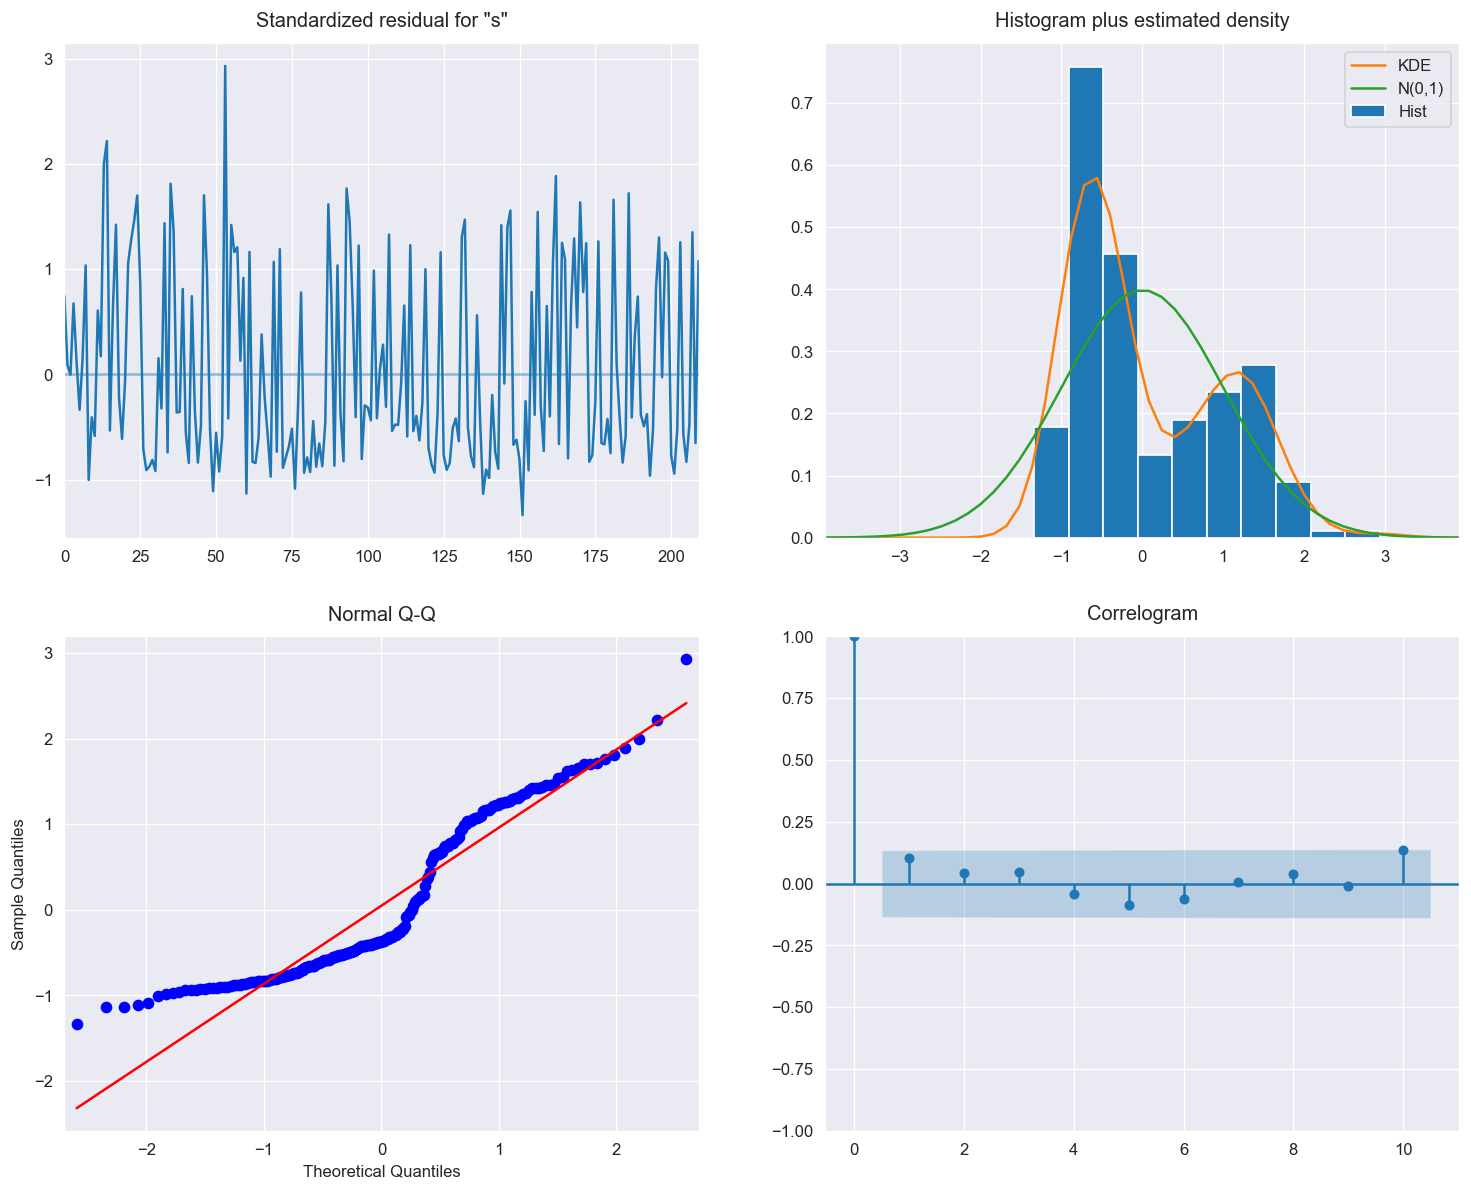

In [468]:
mod = sm.tsa.statespace.SARIMAX(df['sales'],
                                order=(2, 0, 2),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)

results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

Bimodal distribution of residuals suggests model error is not fully corrected
for in ARIMA estimates